Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved.
Portions of this notebook consist of AI-generated content.

Permission is hereby granted, free of charge, to any person obtaining a copy

of this software and associated documentation files (the "Software"), to deal

in the Software without restriction, including without limitation the rights

to use, copy, modify, merge, publish, distribute, sublicense, and/or sell

copies of the Software, and to permit persons to whom the Software is

furnished to do so, subject to the following conditions:



The above copyright notice and this permission notice shall be included in all

copies or substantial portions of the Software.



THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR

IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,

FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE

AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER

LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,

OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE

SOFTWARE.

# DL10 Diffusion Model

### Lab Description

This laboratory exercise introduces Diffusion Models, a powerful class of generative models that progressively convert noise into data through a learned denoising process. Diffusion models have become increasingly popular for high-quality image generation, as seen in models like DALL·E 2 and Stable Diffusion.

In this hands-on lab, you will implement the two main components of a diffusion model—noise injection (forward process) and denoising (reverse process)—and apply them to the `Oxford Flower102` dataset to generate flower images from pure noise.

### What you can expect to learn

- Theoretical Understanding: Understand the mathematical foundation of diffusion models, including the forward and reverse processes.

- Noise Schedule & Forward Process: Learn how to add noise to images using a predefined variance schedule.

- Model Design: Implement a simple U-Net model to predict added noise.

- Sampling: Learn how to reverse the diffusion process to generate realistic images from random noise.

### Import necessary libraries

In [1]:
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' #without this my kernel keep crashing with plt
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
import sys

log_path = os.path.expanduser("~/data/diff_ckpt/diff_log.txt")
sys.stdout = open(log_path, "w")
sys.stderr = sys.stdout

### Required Dataset
We use `Oxford Flower102` dataset for this lab.
More information can be found on the website: https://www.kaggle.com/datasets/nunenuh/pytorch-challange-flower-dataset

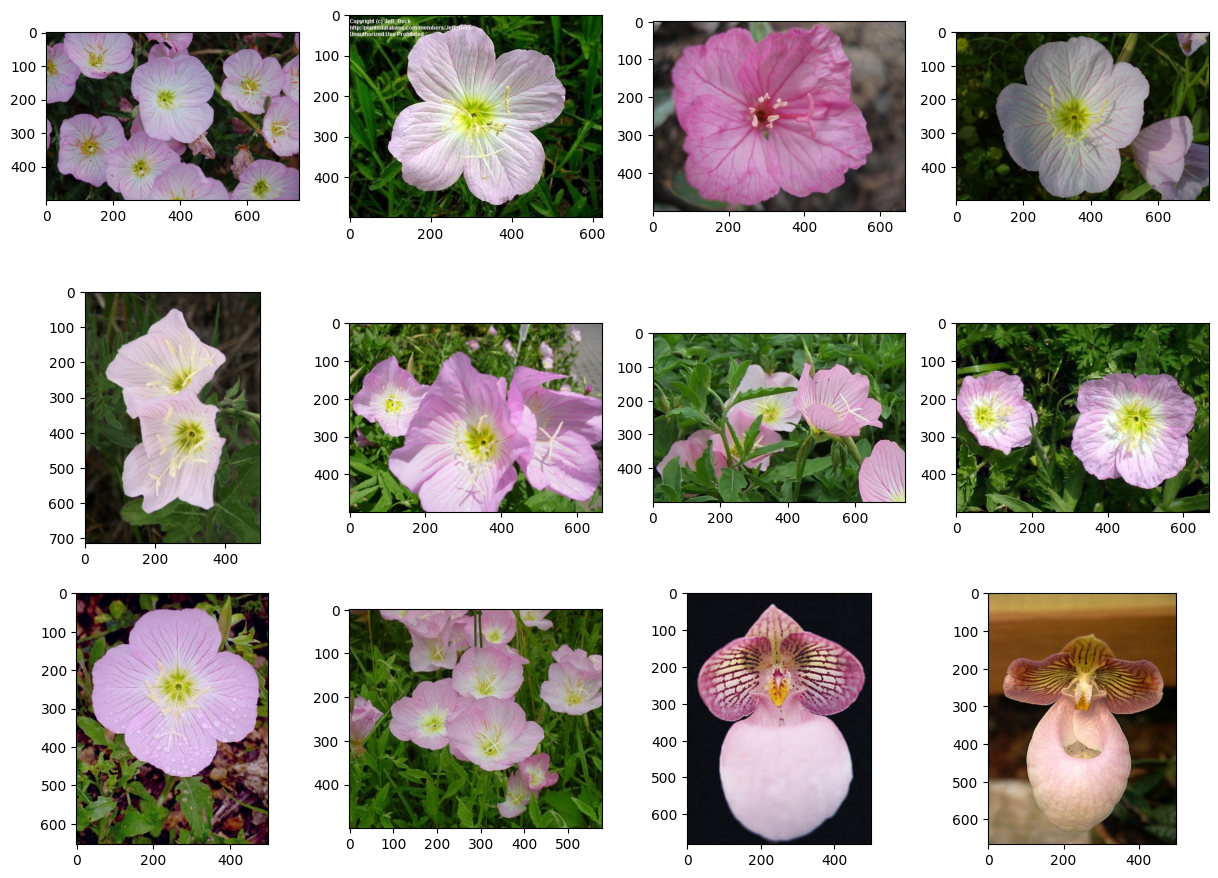

In [ ]:
def show_image(dataset, n=12, cols=4):
    """Plots some sample from the dataset"""
    plt.figure(figsize=(15, 15))
    for i, img in enumerate(dataset):
        if i == n:
            break
        plt.subplot(int(n / cols) + 1, cols, i + 1)
        plt.imshow(img[0])


root_dir = os.path.expanduser("~/data/flower102")
os.makedirs(root_dir, exist_ok=True)

# Download Flowers102 dataset
data = torchvision.datasets.Flowers102(root=root_dir, download=True)

show_image(data)

### Dataset Preprocessing
In this section, we prepare the `Oxford Flower102` dataset for training. We apply common preprocessing steps to improve training stability and efficiency:

- Resize all images to a fixed resolution of 64×64 pixels

- Apply random horizontal flipping for data augmentation

- Normalize pixel values from [0, 1] to [-1, 1], which matches the typical input range for many deep learning models using tanh


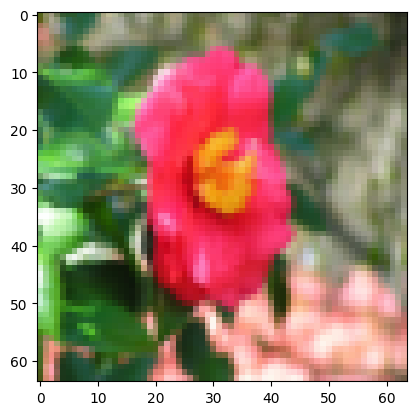

In [4]:
IMG_SIZE = 64
BATCH_SIZE = 128


def transform_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1),
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.Flowers102(root=root_dir, download=True, transform=data_transform)
    test = torchvision.datasets.Flowers102(root=root_dir, download=True, transform=data_transform, split="test")
    return torch.utils.data.ConcatDataset([train, test])


def show_tensor_image(image):
    reverse_transforms = transforms.Compose(
        [
            transforms.Lambda(lambda t: (t + 1) / 2),
            transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW to HWC
            transforms.Lambda(lambda t: t * 255.0),
            transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
            transforms.ToPILImage(),
        ]
    )

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))


data = transform_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

image = next(iter(dataloader))[0]
show_tensor_image(image)

### Denoising Diffusion Probabilistic Model (DDPM)
In this section, we implement a simplified version of a **Denoising Diffusion Probabilistic Model (DDPM)**. The model learns to reverse a gradual noise-adding process, transforming random noise into realistic flower images.

We also precompute constants needed during forward and reverse processes.

### Forward Process (Add Noise)
In the forward process of a diffusion model, we progressively add noise to a clean image `x₀` over `T` timesteps, generating a sequence of noisy images `x₁, x₂, ..., x_T`. This helps the model learn how to reverse this noise and recover the original image.



### Mathematical Formulation
At each timestep t, the noisy image is sampled from:

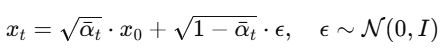

In [5]:
def linear_beta_scheduler(timesteps, start=0.0001, end=0.008):
    return torch.linspace(start, end, timesteps)


def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image, a timestep and a noise scheduler as input and
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(linear_sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(linear_sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(
        device
    ), noise.to(device)


# Pre compute betas and alphas
T = 300

linear_betas = linear_beta_scheduler(T)
linear_alphas = 1.0 - linear_betas
linear_alphas_cumprod = torch.cumprod(linear_alphas, axis=0)
linear_sqrt_alphas_cumprod = torch.sqrt(linear_alphas_cumprod)
linear_sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - linear_alphas_cumprod)
linear_sqrt_recip_alphas = torch.sqrt(1.0 / linear_alphas)
linear_alphas_cumprod_prev = F.pad(linear_alphas_cumprod[:-1], (1, 0), value=1.0)
linear_posterior_variance = linear_betas * (1.0 - linear_alphas_cumprod_prev) / (1.0 - linear_alphas_cumprod)

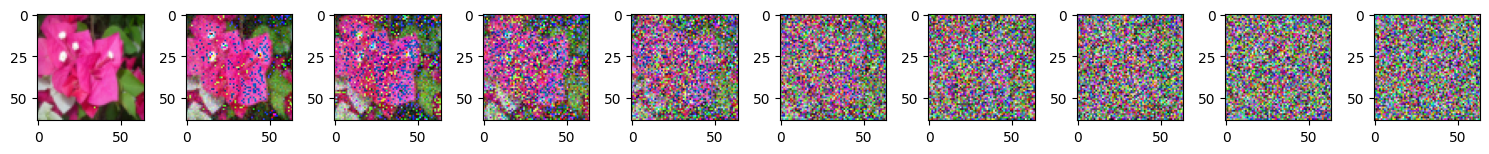

In [6]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15, 5))
num_images = 10
stepsize = int(T / num_images)


for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(2, num_images, int(idx / stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

plt.tight_layout()

### U-Net Backbone
We define a very simple U-Net-like network to predict the noise added to an image.

In [7]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [8]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(
            time_emb_dim, out_ch
        )  # the time emb need to be the same size than the current number of channels
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(
        self,
        x,
        t,
    ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(...,) + (None,) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

In [9]:
class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """

    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim), nn.Linear(time_emb_dim, time_emb_dim), nn.ReLU()
        )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList(
            [Block(down_channels[i], down_channels[i + 1], time_emb_dim) for i in range(len(down_channels) - 1)]
        )
        # Upsample
        self.ups = nn.ModuleList(
            [Block(up_channels[i], up_channels[i + 1], time_emb_dim, up=True) for i in range(len(up_channels) - 1)]
        )

        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)


model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

In [10]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device=device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [11]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(linear_betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(linear_sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = get_index_from_list(linear_sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)
    posterior_variance_t = get_index_from_list(linear_posterior_variance, t, x.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise


@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15, 3))
    plt.axis("off")
    num_images = 10
    stepsize = int(T / num_images)

    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i / stepsize) + 1)
            show_tensor_image(img.detach().cpu())
    plt.show()

### Training Loop
We train the model to predict the noise `ε` given the noisy image `x_t` and the timestep `T`.

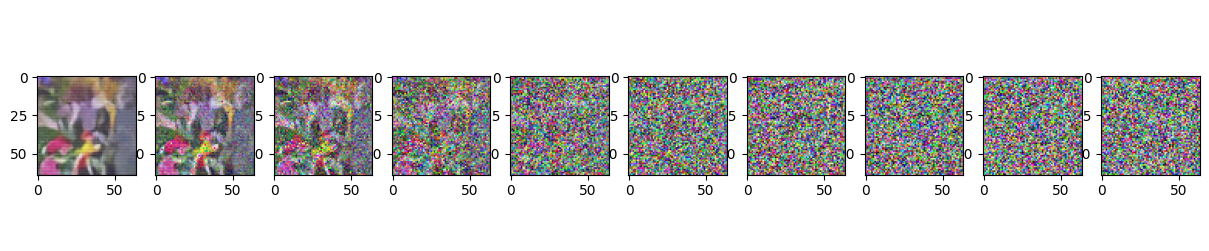

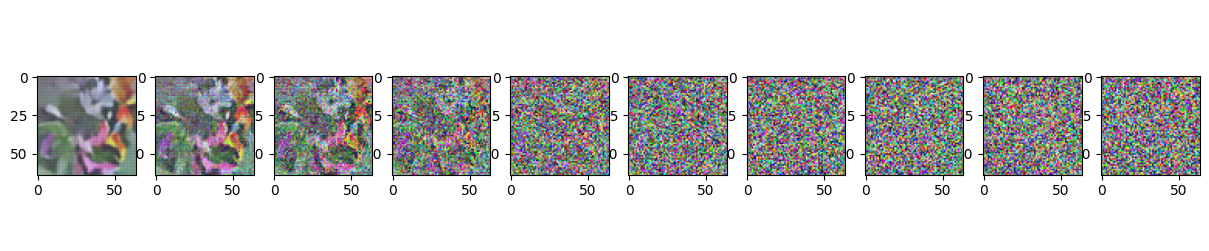

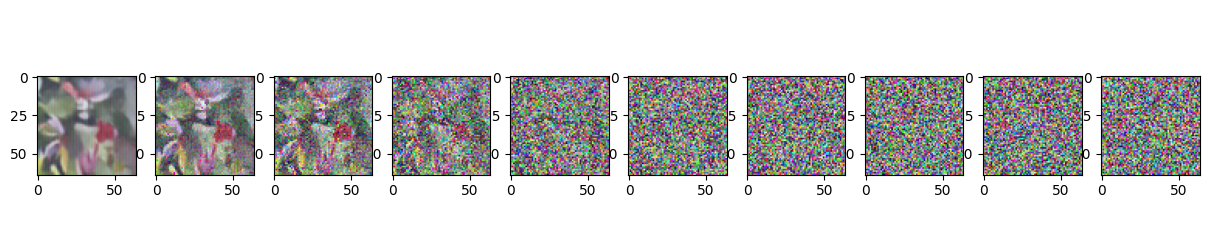

In [ ]:
import datetime
import glob
import os
import re
import sys

import torch

# dataset / dataloader
data = transform_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# device
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device : {device}")

if device.type == "cuda":
    print("cuda index:", torch.cuda.current_device())
    print("cuda name :", torch.cuda.get_device_name(torch.cuda.current_device()))

model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

# ---- log.txt ----
CKPT_DIR = os.path.expanduser("~/data/diff_ckpt")
os.makedirs(CKPT_DIR, exist_ok=True)

log_path = os.path.join(CKPT_DIR, "diff_log.txt")
log_f = open(log_path, "a", buffering=1)
sys.stdout = log_f
sys.stderr = log_f
print(f"\n===== Resume/Start at {datetime.datetime.now().isoformat(timespec='seconds')} =====")


def find_latest_ckpt(ckpt_dir: str):
    pattern = re.compile(r"epoch_(\d+)\.pth$")
    epoch_ckpts = []
    for p in glob.glob(os.path.join(ckpt_dir, "epoch_*.pth")):
        m = pattern.search(os.path.basename(p))
        if m:
            epoch_ckpts.append((int(m.group(1)), p))
    if epoch_ckpts:
        epoch_ckpts.sort()
        return epoch_ckpts[-1][1]
    last_p = os.path.join(ckpt_dir, "last.pth")
    return last_p if os.path.exists(last_p) else None


start_epoch = 0
latest = find_latest_ckpt(CKPT_DIR)
if latest:
    print(f"[resume] loading ckpt: {latest}")
    ckpt = torch.load(latest, map_location="cpu")
    try:
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        for state in optimizer.state.values():
            for k, v in state.items():
                if torch.is_tensor(v):
                    state[k] = v.to(device)
        start_epoch = int(ckpt.get("epoch", 0))
        print(f"[resume] start from epoch {start_epoch + 1}")
    except Exception as e:
        print(f"[resume] failed to load state dicts: {e}\n[resume] training from scratch.")

# ---- Training loop ----

epochs = 300
global_step = 0
for epoch in range(epochs):
    model.train()
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        x = batch[0].to(device)
        t = torch.randint(0, T, (x.size(0),), device=device).long()

        loss = get_loss(model, x, t)
        loss.backward()
        optimizer.step()

        if step == 0:
            print(f"Epoch {epoch + 1}/{epochs} | step {step:03d} Loss: {loss.item():.6f}")

        if (epoch % 5 == 0) and (step == 0):
            sample_plot_image()

        global_step += 1

    if (epoch + 1) % 10 == 0:
        ckpt_path = os.path.join(CKPT_DIR, f"epoch_{epoch + 1:03d}.pth")
        torch.save(
            {
                "epoch": epoch + 1,
                "global_step": global_step,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "last_loss": float(loss.item()),
                "rng_state": torch.get_rng_state(),
                "cuda_rng_state": torch.cuda.get_rng_state_all() if device.type == "cuda" else None,
            },
            ckpt_path,
        )
        print(f"[ckpt] saved: {ckpt_path}")

### Reverse Sampling (Generation)
We start from pure noise and iteratively apply the learned denoising steps to generate images.

### Visualization

In [ ]:
@torch.no_grad()
def generate_image(noise):
    """
    Generate one image from random noise using the trained Unet
    """
    image = noise
    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        image = sample_timestep(image, t)
        if i == 0:
            return image

In [ ]:
n = 10
plt.figure(figsize=(15, 15))
plt.axis("off")
for i in range(0, n):
    noise = torch.randn((1, 3, IMG_SIZE, IMG_SIZE), device=device)
    image = generate_image(noise)
    plt.subplot(1, n, i + 1)
    show_tensor_image(image.detach().cpu())
plt.show()